In [1]:
from root_pandas import read_root
import pandas as pd
import ROOT as root
import utility_common as common
from pylab import *
from utility_dfplotter import ASingleKinematicPlot
from utility_bltreader import BLTReader
%matplotlib inline

Welcome to JupyROOT 6.16/00


In [15]:
namelist = {
    "VV"   : [ 'ww','wz_2l2q','wz_3lnu','zz_2l2nu','zz_2l2q','zz_4l'],
    "Z"    : [ 'zjets_m-50_amcatnlo','zjets_m-10to50_amcatnlo'],
    "W"    : [ 'w1jets','w2jets','w3jets','w4jets' ],
    "Top"  : [ 'ttbar_inclusive'],
    "Data" : ['electron_2016B', 'electron_2016C','electron_2016D','electron_2016E','electron_2016F','electron_2016G','electron_2016H']
}

xsTable = { 
            # diboson
            'ww'              : 12178,
            'wz_2l2q'         : 5595,
            'wz_3lnu'         : 4430,
            'zz_2l2nu'        : 564,
            'zz_2l2q'         : 3220,
            'zz_4l'           : 1210,
            # Z
            'zjets_m-10to50_amcatnlo'  : 18610000,
            'zjets_m-50_amcatnlo'      :  5765400,
            # W
            'w1jets'          :  9493000,
            'w2jets'          :  3120000,
            'w3jets'          :  942300,
            'w4jets'          :  524100,
            # top
            't_tw'            :  35850,
            'tbar_tw'         :  35850,
            'ttbar_inclusive' :  832000
        }

In [16]:
def loadDataFrame(dataset):
    fileName = "../../data/root/eleTriggerEff.root"
    inputRootFile = root.TFile(fileName)
    lumin = 35.864
    
    dflist = []
    for name in namelist[dataset]:
        df = read_root(fileName,"ee/bltTree_"+name)
        df["eventWeightRaw"] = df.eventWeight * df.genWeight
        if not ("electron_2016" in name):
            xs = xsTable[name]
            histogram = inputRootFile.Get('TotalEvents_'+name)
            nGenTotal = histogram.GetBinContent(1) - 2*histogram.GetBinContent(10)
            scaleFactor = lumin * xs/nGenTotal
            
            #print(nGenTotal,scaleFactor)
            df.eventWeight *= scaleFactor * df.genWeight
            df["era"] = "nan"
        else:
            df["era"] = name[-1]
        
        df["leptonOneIsTag"] = (df.leptonOnePt>tagPtThreshold) & (df.leptonOneNotInGap==1) & (df.leptonOnePassTriggerTest==1)
        df["leptonTwoIsTag"] = (df.leptonTwoPt>tagPtThreshold) & (df.leptonTwoNotInGap==1) & (df.leptonTwoPassTriggerTest==1)
        
        df.query("leptonOneIsTag==1 | leptonTwoIsTag==1",inplace=True)
        df.reset_index(drop=True,inplace=True)
        dflist.append(df)
    dataFrame = pd.concat(dflist)
    return dataFrame

def getTagProbPairDataFrame(df):
    temp1 = df.query("leptonOneIsTag==1")
    temp2 = df.query("leptonTwoIsTag==1")

    dfpair = pd.DataFrame()
    dfpair["era"] = np.r_[temp1["era"].values, temp2["era"].values]
    dfpair["eventWeight"] = np.r_[temp1["eventWeight"].values, temp2["eventWeight"].values]
    dfpair["eventWeightRaw"] = np.r_[temp1["eventWeightRaw"].values, temp2["eventWeightRaw"].values]

    dfpair["tagPt"]       = np.r_[temp1["leptonOnePt"].values,  temp2["leptonTwoPt"].values]
    dfpair["probPt"]      = np.r_[temp1["leptonTwoPt"].values,  temp2["leptonOnePt"].values]
    dfpair["probEta"]     = np.r_[temp1["leptonTwoEta"].values, temp2["leptonOneEta"].values]
    dfpair["probPass"]    = np.r_[temp1["leptonTwoPassTriggerTest"].values, 
                                  temp2["leptonOnePassTriggerTest"].values]
    return dfpair

In [5]:
for tagPtThreshold in [30,40]:
    Data = loadDataFrame("Data")
    MCvv = loadDataFrame("VV")
    MCw  = loadDataFrame("W")
    MCt  = loadDataFrame("Top")
    MCz  = loadDataFrame("Z")

    DataPair = getTagProbPairDataFrame(Data)
    MCPair = getTagProbPairDataFrame(pd.concat([MCt,MCz]))
    DataPair.to_pickle("../../data/eleTriggerEff/DataPair_tag{}.pkl".format(tagPtThreshold))
    MCPair.to_pickle("../../data/eleTriggerEff/MCPair_tag{}.pkl".format(tagPtThreshold))
    
#     # make a plot
#     v,a,b,step,xl = "dileptonMass", 60,120, 2, r"$m_{ee} [GeV]$"
#     sk = ASingleKinematicPlot(v,a,b,step,dfList)
#     sk.settingPlot(xl,['EW','W','Top','Z','Data'],['#a32020','#eb8c00','springgreen','deepskyblue','k'])
#     sk.makePlot()
#     plt.savefig("../../plots/eleTriggerEff/dileptonMass_tag{}.png".format(tagPtThreshold),dpi=300)
#     plt.close()

# 2. Plot Tag-Prob Pairs

In [6]:
tagPtThreshold = 30

In [7]:
DataPair = pd.read_pickle("../../data/eleTriggerEff/DataPair_tag{}.pkl".format(tagPtThreshold))
MCPair = pd.read_pickle("../../data/eleTriggerEff/MCPair_tag{}.pkl".format(tagPtThreshold))

In [10]:
v,a,b,step,xl = "probPt", 20,201, 5, r"$p^T_{e}$ [GeV]"
mybin = np.array([25,28,30,32,34,36,38,40,42,44,46,48,50,55,60,65,70,80,90,100,120,200,1000])

# v,a,b,step,xl = "probEta", -3,3.1, 0.2, r"$\eta_{e}$"
# mybin = np.array([-2.5, -2.0, -1.8, -1.560, -1.444, -1.1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.1, 1.444, 1.560, 1.8, 2.0, 2.5])

mycernter = (mybin[:-1] + mybin[1:])/2
mystep = (mybin[:-1] - mybin[1:])

# data efficiency
den,_ = np.histogram(DataPair[v], mybin, weights=DataPair.eventWeight)
num,_ = np.histogram(DataPair[v], mybin, weights=DataPair.eventWeight * DataPair.probPass)
dataEff,dataEffVar = common.getEfficiency(num, den)

# mc efficiency
den,_ = np.histogram(MCPair[v], mybin, weights=MCPair.eventWeightRaw)
num,_ = np.histogram(MCPair[v], mybin, weights=MCPair.eventWeightRaw * MCPair.probPass)
mcEff,mcEffVar = common.getEfficiency(num, den)

# scale factor
sf, sfVar = common.getRatio(dataEff, mcEff, dataEffVar, mcEffVar)

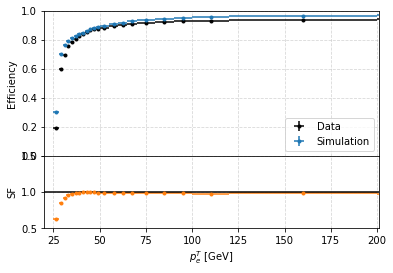

In [11]:
fig, axes = plt.subplots(2, 1, sharex=True, facecolor='w',
                         gridspec_kw={'height_ratios':[2,1]},
                         figsize=(6,4))
fig.subplots_adjust(hspace=0)

ax = axes[0]
ax.errorbar(mycernter, dataEff, xerr=mystep/2, yerr=sqrt(dataEffVar), fmt=".",color='k',label="Data")
ax.errorbar(mycernter, mcEff, xerr=mystep/2, yerr=sqrt(mcEffVar), fmt=".",color='C0',label="Simulation")
ax.set_ylabel("Efficiency")
ax.legend()
ax.grid(linestyle="--",alpha=0.5)
ax.set_ylim(0,1)

ax = axes[1]
ax.errorbar(mycernter, sf,xerr=mystep/2,yerr=sqrt(sfVar),  fmt=".",color='C1')
ax.set_xlabel(xl)
ax.set_ylabel("SF")
ax.set_ylim(0.5,1.5)
ax.set_xlim(a,b)
ax.legend()
ax.grid(linestyle="--",alpha=0.5)
ax.axhline(1,color='k')

plt.savefig("../../plots/eleTriggerEff/" + v + ".png",dpi=300)

# 3. SF in 2D

In [12]:
tagPtThreshold = 30
DataPairRaw = pd.read_pickle("../../data/eleTriggerEff/DataPair_tag{}.pkl".format(tagPtThreshold))
MCPair = pd.read_pickle("../../data/eleTriggerEff/MCPair_tag{}.pkl".format(tagPtThreshold))
v1,a1,b1,step1,xl1 = "probPt", 20,161, 5, r"$p^T_{e}$ [GeV]"
v2,a2,b2,step2,xl2 = "probEta", -3,3.1, 0.2, r"$\eta_{e}$"

In [13]:
v1,a1,b1,step1,xl1 = "probPt", 20,161, 5, r"$p^T_{e}$ [GeV]"
v2,a2,b2,step2,xl2 = "probEta", -3,3.1, 0.2, r"$\eta_{e}$"

mybin1 = np.array([25,28,30,32,34,36,38,40,42,44,46,48,50,55,60,65,70,80,90,100,120,200,1000])
mybin2 = np.array([-2.5, -2.0, -1.8, -1.560, -1.444, -1.1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.1, 1.444, 1.560, 1.8, 2.0, 2.5])
mycernter2 = (mybin2[:-1]+ mybin2[1:])/2
mystep1 = (mybin1[:-1] - mybin1[1:])
mystep2 = (mybin2[:-1] - mybin2[1:])
    
def getEffAndSf(era):
    if era == "full":
        DataPair = DataPairRaw
    if era == "BCDEF":
        DataPair = DataPairRaw.query("era=='B' | era=='C' | era=='D' | era=='E' | era=='F'")
    if era == "GH":
        DataPair = DataPairRaw.query("era=='G' | era=='H'")
    if len(era) == 1:
        slt = DataPairRaw.era.values == era
        DataPair = DataPairRaw[slt]
        
    den,_,__ = np.histogram2d(DataPair[v1], DataPair[v2], bins=(mybin1,mybin2), weights=DataPair.eventWeight)
    num,_,__ = np.histogram2d(DataPair[v1], DataPair[v2], bins=(mybin1,mybin2), weights=DataPair.eventWeight * DataPair.probPass)   
    dataEff,dataEffVar = common.getEfficiency(num, den)
    
    den,_,__ = np.histogram2d(MCPair[v1], MCPair[v2], bins=(mybin1,mybin2), weights=MCPair.eventWeightRaw )
    num,_,__ = np.histogram2d(MCPair[v1], MCPair[v2], bins=(mybin1,mybin2), weights=MCPair.eventWeightRaw * MCPair.probPass)
    mcEff,mcEffVar = common.getEfficiency(num, den)
    

#     den,_,__ = np.histogram2d(DataPair[v1], DataPair[v2], bins=(mybin1,mybin2), weights=DataPair.eventWeight)
#     num,_,__ = np.histogram2d(DataPair[v1], DataPair[v2], bins=(mybin1,mybin2), weights=DataPair.eventWeight * DataPair.probPass)
#     denVar,_,__ = np.histogram2d(DataPair[v1], DataPair[v2], bins=(mybin1,mybin2), weights=DataPair.eventWeight**2)
#     numVar,_,__ = np.histogram2d(DataPair[v1], DataPair[v2], bins=(mybin1,mybin2), weights=DataPair.eventWeight**2 * DataPair.probPass)
#     dataEff,dataEffVar = common.getRatio(num, den, numVar, denVar)

#     den,_,__ = np.histogram2d(MCPair[v1], MCPair[v2], bins=(mybin1,mybin2), weights=MCPair.eventWeight)
#     num,_,__ = np.histogram2d(MCPair[v1], MCPair[v2], bins=(mybin1,mybin2), weights=MCPair.eventWeight * MCPair.probPass)
#     den,_,__ = np.histogram2d(MCPair[v1], MCPair[v2], bins=(mybin1,mybin2), weights=MCPair.eventWeight**2)
#     num,_,__ = np.histogram2d(MCPair[v1], MCPair[v2], bins=(mybin1,mybin2), weights=MCPair.eventWeight**2 * MCPair.probPass)
#     mcEff,mcEffVar = common.getRatio(num, den, numVar, denVar)

    sf, sfVar = common.getRatio(dataEff, mcEff, dataEffVar, mcEffVar)
    
    return dataEff,mcEff,sf,sfVar

In [14]:
for era in ["full","BCDEF","GH","B","C","D","E","F","G","H"]:
    dataEff,mcEff,sf,sfVar = getEffAndSf(era)

    plt.figure(figsize=(15,4),facecolor='w')

    plt.subplot(131)
    plt.pcolor(mybin1,mybin2,dataEff.T,cmap="viridis",vmax=1,vmin=0)
    plt.xlabel(xl1)
    plt.ylabel(xl2)
    plt.axhline(1.444,color='w',linestyle="--")
    plt.axhline(1.560,color='w',linestyle="--")
    plt.axhline(-1.444,color='w',linestyle="--")
    plt.axhline(-1.560,color='w',linestyle="--")
    plt.axvline(30,color='k',linestyle="--")
    plt.title("Trigger Efficiency (Data {})".format(era))
    plt.xlim(25,200)
    plt.colorbar()

    plt.subplot(132)
    plt.pcolor(mybin1,mybin2,mcEff.T,cmap="viridis",vmax=1,vmin=0)
    plt.xlabel(xl1)
    plt.ylabel(xl2)
    plt.axhline(1.444,color='w',linestyle="--")
    plt.axhline(1.560,color='w',linestyle="--")
    plt.axhline(-1.444,color='w',linestyle="--")
    plt.axhline(-1.560,color='w',linestyle="--")
    plt.axvline(30,color='k',linestyle="--")
    plt.title("Trigger Efficiency (Simulation)")
    plt.xlim(25,200)
    plt.colorbar()


    plt.subplot(133)
    plt.pcolor(mybin1,mybin2,sf.T,cmap="Spectral",vmax=1.05,vmin=0.7)
    plt.xlabel(xl1)
    plt.ylabel(xl2)
    plt.axhline(1.444,color='k',linestyle="--")
    plt.axhline(1.560,color='k',linestyle="--")
    plt.axhline(-1.444,color='k',linestyle="--")
    plt.axhline(-1.560,color='k',linestyle="--")
    plt.axvline(30,color='k',linestyle="--")
    plt.title("Scale Factor 2016{}".format(era))
    plt.xlim(25,200)
    plt.colorbar()


    plt.savefig("../../plots/eleTriggerEff/eff2d_{}.png".format(era),dpi=300)
    plt.close()
    
    if len(era)==1:
        plt.figure(figsize=(5,4),facecolor='w')
    else:
        plt.figure(figsize=(8,4),facecolor='w')
    plt.pcolor(mybin1,mybin2,sf.T,cmap="Spectral",vmax=1.05,vmin=0.7)
    plt.xlabel(xl1)
    plt.ylabel(xl2)
    plt.axhline(1.444,color='k',linestyle="--")
    plt.axhline(1.560,color='k',linestyle="--")
    plt.axhline(-1.444,color='k',linestyle="--")
    plt.axhline(-1.560,color='k',linestyle="--")
    plt.axvline(30,color='k',linestyle="--")
    plt.title("Scale Factor 2016{}".format(era))
    plt.xlim(25,200)
    plt.colorbar()
    plt.savefig("../../plots/eleTriggerEff/sf2d_{}.png".format(era),dpi=300)
    plt.close()

# 4. Plot A.Popov

In [22]:
era = "GH"
fileName = "../../data/eleTriggerEff/TriggerSF_Run2016{}_v1.root".format(era)
inputRootFile = root.TFile(fileName)
hist2d = inputRootFile.Get("Ele27_WPTight_Gsf")

In [23]:
mybin1 = np.array([25,28,30,32,34,36,38,40,42,44,46,48,50,55,60,65,70,80,90,100,120,200])
mybin2 = np.array([-2.5, -2.0, -1.8, -1.560, -1.444, -1.1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.1, 1.444, 1.560, 1.8, 2.0, 2.5])

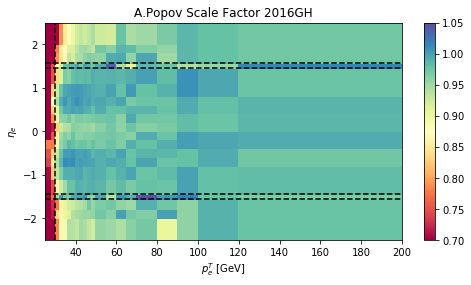

In [ ]:
h = []
for i in range(1,hist2d.GetNbinsX()+1):
    temp = []
    for j in range(1, hist2d.GetNbinsY()+1):
        temp.append(hist2d.GetBinContent(i,j))
    h.append(temp)
h = np.array(h)
plt.figure(figsize=(8,4),facecolor='w')
plt.pcolor(mybin1,mybin2,h.T,cmap="Spectral",vmax=1.05,vmin=0.7)
plt.xlabel(xl1)
plt.ylabel(xl2)
plt.axhline(1.444,color='k',linestyle="--")
plt.axhline(1.560,color='k',linestyle="--")
plt.axhline(-1.444,color='k',linestyle="--")
plt.axhline(-1.560,color='k',linestyle="--")
plt.axvline(30,color='k',linestyle="--")
plt.title("A.Popov Scale Factor 2016{}".format(era))
plt.xlim(25,200)
plt.colorbar()
plt.savefig("../../plots/eleTriggerEff/APopov_sf2d_{}.png".format(era),dpi=300)

In [ ]:
dataEff,mcEff,sf,sfVar = getEffAndSf(era)

In [ ]:
plt.figure(figsize=(8,4),facecolor='w')
plt.pcolor(mybin1,mybin2,(sf.T-h.T)/h.T,cmap="RdBu",vmax=0.1,vmin=-0.1)
plt.xlabel(xl1)
plt.ylabel(xl2)
plt.axhline(1.444,color='k',linestyle="--")
plt.axhline(1.560,color='k',linestyle="--")
plt.axhline(-1.444,color='k',linestyle="--")
plt.axhline(-1.560,color='k',linestyle="--")
plt.axvline(30,color='k',linestyle="--")
plt.title("(Ours-A.Popov)/A.Popov 2016{}".format(era))
plt.colorbar()
plt.savefig("../../plots/eleTriggerEff/APopovDiff_sf2d_{}.png".format(era),dpi=300)